
# Multi-class AdaBoosted Decision Trees

This example shows how boosting can improve the prediction accuracy on a
multi-label classification problem. It reproduces a similar experiment as
depicted by Figure 1 in Zhu et al [1]_.

The core principle of AdaBoost (Adaptive Boosting) is to fit a sequence of weak
learners (e.g. Decision Trees) on repeatedly re-sampled versions of the data.
Each sample carries a weight that is adjusted after each training step, such
that misclassified samples will be assigned higher weights. The re-sampling
process with replacement takes into account the weights assigned to each sample.
Samples with higher weights have a greater chance of being selected multiple
times in the new data set, while samples with lower weights are less likely to
be selected. This ensures that subsequent iterations of the algorithm focus on
the difficult-to-classify samples.

.. topic:: References:

    .. [1] :doi:`J. Zhu, H. Zou, S. Rosset, T. Hastie, "Multi-class adaboost."
           Statistics and its Interface 2.3 (2009): 349-360.
           <10.4310/SII.2009.v2.n3.a8>`


In [ ]:
# Noel Dawe <noel.dawe@gmail.com>
# License: BSD 3 clause

## Creating the dataset
The classification dataset is constructed by taking a ten-dimensional standard
normal distribution ($x$ in $R^{10}$) and defining three classes
separated by nested concentric ten-dimensional spheres such that roughly equal
numbers of samples are in each class (quantiles of the $\chi^2$
distribution).



In [14]:
from sklearn.datasets import make_gaussian_quantiles

X, y = make_gaussian_quantiles(
    n_samples=2_000, n_features=10, n_classes=3, random_state=1
)


In [15]:
y

array([0, 1, 1, ..., 0, 0, 2])

We split the dataset into 2 sets: 70 percent of the samples are used for
training and the remaining 30 percent for testing.



In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42
)

## Training the `AdaBoostClassifier`
We train the :class:`~sklearn.ensemble.AdaBoostClassifier`. The estimator
utilizes boosting to improve the classification accuracy. Boosting is a method
designed to train weak learners (i.e. `base_estimator`) that learn from their
predecessor's mistakes.

Here, we define the weak learner as a
:class:`~sklearn.tree.DecisionTreeClassifier` and set the maximum number of
leaves to 8. In a real setting, this parameter should be tuned. We set it to a
rather low value to limit the runtime of the example.

The `SAMME` algorithm build into the
:class:`~sklearn.ensemble.AdaBoostClassifier` then uses the correct or
incorrect predictions made be the current weak learner to update the sample
weights used for training the consecutive weak learners. Also, the weight of
the weak learner itself is calculated based on its accuracy in classifying the
training examples. The weight of the weak learner determines its influence on
the final ensemble prediction.



In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

weak_learner = DecisionTreeClassifier(max_leaf_nodes=8)
n_estimators = 300

adaboost_clf = AdaBoostClassifier(
    estimator=weak_learner,
    n_estimators=n_estimators,
    algorithm="SAMME",
    random_state=42,
).fit(X_train, y_train)

## Analysis
Convergence of the `AdaBoostClassifier`
***************************************
To demonstrate the effectiveness of boosting in improving accuracy, we
evaluate the misclassification error of the boosted trees in comparison to two
baseline scores. The first baseline score is the `misclassification_error`
obtained from a single weak-learner (i.e.
:class:`~sklearn.tree.DecisionTreeClassifier`), which serves as a reference
point. The second baseline score is obtained from the
:class:`~sklearn.dummy.DummyClassifier`, which predicts the most prevalent
class in a dataset.



In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier()

def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train, y_train).predict(X_test)
)

dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train, y_train).predict(X_test)     
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)

print(
    "DummyClassifier's misclassification_error: "
    f"{dummy_classifiers_misclassification_error:.3f}"
)


DecisionTreeClassifier's misclassification_error: 0.475
DummyClassifier's misclassification_error: 0.692


After training the :class:`~sklearn.tree.DecisionTreeClassifier` model, the
achieved error surpasses the expected value that would have been obtained by
guessing the most frequent class label, as the
:class:`~sklearn.dummy.DummyClassifier` does.

Now, we calculate the `misclassification_error`, i.e. `1 - accuracy`, of the
additive model (:class:`~sklearn.tree.DecisionTreeClassifier`) at each
boosting iteration on the test set to assess its performance.

We use :meth:`~sklearn.ensemble.AdaBoostClassifier.staged_predict` that makes
as many iterations as the number of fitted estimator (i.e. corresponding to
`n_estimators`). At iteration `n`, the predictions of AdaBoost only use the
`n` first weak learners. We compare these predictions with the true
predictions `y_test` and we, therefore, conclude on the benefit (or not) of adding a
new weak learner into the chain.

We plot the misclassification error for the different stages:



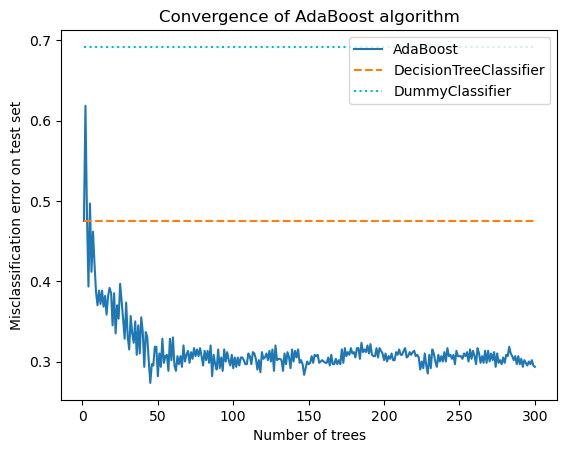

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in adaboost_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost algorithm")

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)
plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [
        dummy_classifiers_misclassification_error,
        dummy_classifiers_misclassification_error,
    ],
    color="c",
    linestyle="dotted",
)
plt.legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=1)
plt.show()

The plot shows the missclassification error on the test set after each
boosting iteration. We see that the error of the boosted trees converges to an
error of around 0.3 after 50 iterations, indicating a significantly higher
accuracy compared to a single tree, as illustrated by the dashed line in the
plot.

The misclassification error jitters because the `SAMME` algorithm uses the
discrete outputs of the weak learners to train the boosted model.

The convergence of :class:`~sklearn.ensemble.AdaBoostClassifier` is mainly
influenced by the learning rate (i.e `learning_rate`), the number of weak
learners used (`n_estimators`), and the expressivity of the weak learners
(e.g. `max_leaf_nodes`).



### Errors and weights of the Weak Learners
As previously mentioned, AdaBoost is a forward stagewise additive model. We
now focus on understanding the relationship between the attributed weights of
the weak learners and their statistical performance.

We use the fitted :class:`~sklearn.ensemble.AdaBoostClassifier`'s attributes
`estimator_errors_` and `estimator_weights_` to investigate this link.



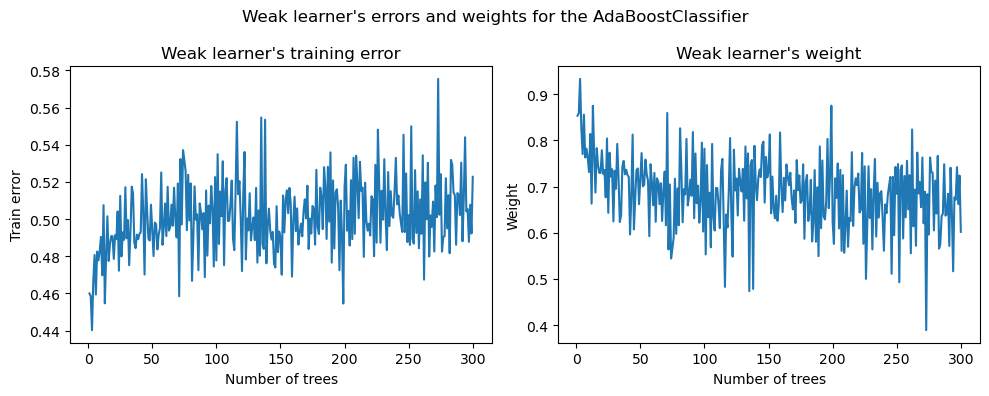

In [9]:
weak_learners_info = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "Errors": adaboost_clf.estimator_errors_,
        "Weights": adaboost_clf.estimator_weights_,
    }
).set_index("Number of trees")

axs = weak_learners_info.plot(
    subplots=True, layout=(1, 2), figsize=(10, 4), legend=False, color="tab:blue"
)
axs[0, 0].set_ylabel("Train error")
axs[0, 0].set_title("Weak learner's training error")
axs[0, 1].set_ylabel("Weight")
axs[0, 1].set_title("Weak learner's weight")
fig = axs[0, 0].get_figure()
fig.suptitle("Weak learner's errors and weights for the AdaBoostClassifier")
fig.tight_layout()

On the left plot, we show the weighted error of each weak learner on the
reweighted training set at each boosting iteration. On the right plot, we show
the weights associated with each weak learner later used to make the
predictions of the final additive model.

We see that the error of the weak learner is the inverse of the weights. It
means that our additive model will trust more a weak learner that makes
smaller errors (on the training set) by increasing its impact on the final
decision. Indeed, this exactly is the formulation of updating the base
estimators' weights after each iteration in AdaBoost.

|details-start| Mathematical details |details-split|

The weight associated with a weak learner trained at the stage $m$ is
inversely associated with its misclassification error such that:

\begin{align}\alpha^{(m)} = \log \frac{1 - err^{(m)}}{err^{(m)}} + \log (K - 1),\end{align}

where $\alpha^{(m)}$ and $err^{(m)}$ are the weight and the error
of the $m$ th weak learner, respectively, and $K$ is the number of
classes in our classification problem. |details-end|

Another interesting observation boils down to the fact that the first weak
learners of the model make fewer errors than later weak learners of the
boosting chain.

The intuition behind this observation is the following: due to the sample
reweighting, later classifiers are forced to try to classify more difficult or
noisy samples and to ignore already well classified samples. Therefore, the
overall error on the training set will increase. That's why the weak learner's
weights are built to counter-balance the worse performing weak learners.

